In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pathlib2

In [3]:
import pickle as pk
import pandas as pd
from pathlib2 import Path
import numpy as np
import os

def pk_read(path):
    with open(path, 'rb') as f:
        D = pk.load(f,encoding='utf8')
    return D

In [4]:
#Load Data
train=pk_read('/content/drive/MyDrive/WashU Deep Learning/Final Project/lc_loan_processed_binary.pk')

In [5]:
test=pk_read('/content/drive/MyDrive/WashU Deep Learning/Final Project/lc_2016_2017_processed_binary.pk')

In [6]:
# Train Test Split
from sklearn.model_selection import train_test_split
train, validation=train_test_split(train,train_size=0.9,stratify=train["loan_status"])

print(train.shape,validation.shape,test.shape)

(791024, 42) (87892, 42) (758834, 42)


In [7]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,delinq,derog,purpose,term,home_ownership,verification_status,recovery,pymnt_received,loan_status
180427,24000.0,24000.0,24000.0,16.29,587.34,2,13,11.0,58000.00,28.76,2.0,2000,1.0,8.0,0.0,11227.0,39.5,34.0,0,0.00,0.00,14866.12,14866.12,6291.96,6039.24,0.0,587.34,0.0,0,0.0,0.0,19953.0,28400.0,1.0,1.0,2,60,4,2,1,1.0,1
31906,14000.0,14000.0,13825.0,10.25,453.39,1,6,11.0,100000.00,9.26,0.0,1993,1.0,8.0,0.0,40267.0,66.2,36.0,1,0.00,0.00,14871.95,14686.03,14000.00,871.95,0.0,11719.49,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,36,0,0,0,1.0,0
810864,9250.0,9250.0,9250.0,13.33,313.15,2,12,0.0,42000.00,21.97,0.0,1988,3.0,9.0,2.0,2737.0,33.0,48.0,1,7270.07,7270.07,2827.84,2827.84,1979.93,847.91,0.0,313.15,0.0,0,0.0,0.0,22631.0,8410.0,1.0,1.0,4,36,3,2,0,1.0,0
687363,24000.0,24000.0,24000.0,18.25,612.72,4,20,10.0,58197.06,21.00,0.0,2005,0.0,12.0,0.0,14649.0,91.3,25.0,0,22456.01,22456.01,3651.99,3651.99,1543.99,2108.00,0.0,612.72,0.0,0,0.0,0.0,172903.0,16000.0,1.0,1.0,1,60,0,1,0,1.0,0
524705,10000.0,10000.0,10000.0,10.99,327.34,1,8,11.0,83000.00,12.29,2.0,1993,1.0,19.0,0.0,11400.0,57.3,24.0,1,9526.33,9526.33,648.57,648.57,473.67,174.90,0.0,327.34,0.0,0,0.0,0.0,165160.0,19900.0,1.0,0.0,1,36,0,1,0,1.0,0


In [8]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,delinq,derog,purpose,term,home_ownership,verification_status,recovery,pymnt_received,loan_status
180427,24000.0,24000.0,24000.0,16.29,587.34,2,13,11.0,58000.00,28.76,2.0,2000,1.0,8.0,0.0,11227.0,39.5,34.0,0,0.00,0.00,14866.12,14866.12,6291.96,6039.24,0.0,587.34,0.0,0,0.0,0.0,19953.0,28400.0,1.0,1.0,2,60,4,2,1,1.0,1
31906,14000.0,14000.0,13825.0,10.25,453.39,1,6,11.0,100000.00,9.26,0.0,1993,1.0,8.0,0.0,40267.0,66.2,36.0,1,0.00,0.00,14871.95,14686.03,14000.00,871.95,0.0,11719.49,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,36,0,0,0,1.0,0
810864,9250.0,9250.0,9250.0,13.33,313.15,2,12,0.0,42000.00,21.97,0.0,1988,3.0,9.0,2.0,2737.0,33.0,48.0,1,7270.07,7270.07,2827.84,2827.84,1979.93,847.91,0.0,313.15,0.0,0,0.0,0.0,22631.0,8410.0,1.0,1.0,4,36,3,2,0,1.0,0
687363,24000.0,24000.0,24000.0,18.25,612.72,4,20,10.0,58197.06,21.00,0.0,2005,0.0,12.0,0.0,14649.0,91.3,25.0,0,22456.01,22456.01,3651.99,3651.99,1543.99,2108.00,0.0,612.72,0.0,0,0.0,0.0,172903.0,16000.0,1.0,1.0,1,60,0,1,0,1.0,0
524705,10000.0,10000.0,10000.0,10.99,327.34,1,8,11.0,83000.00,12.29,2.0,1993,1.0,19.0,0.0,11400.0,57.3,24.0,1,9526.33,9526.33,648.57,648.57,473.67,174.90,0.0,327.34,0.0,0,0.0,0.0,165160.0,19900.0,1.0,0.0,1,36,0,1,0,1.0,0


In [9]:
x_train = train.drop('loan_status',axis =1)
x_test = test.drop('loan_status',axis =1)
x_validation = validation.drop('loan_status',axis =1)

y_train = train['loan_status']
y_test = test['loan_status']
y_validation = validation['loan_status']
y_train.shape

(791024,)

In [10]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,delinq,derog,purpose,term,home_ownership,verification_status,recovery,pymnt_received,loan_status
180427,24000.0,24000.0,24000.0,16.29,587.34,2,13,11.0,58000.00,28.76,2.0,2000,1.0,8.0,0.0,11227.0,39.5,34.0,0,0.00,0.00,14866.12,14866.12,6291.96,6039.24,0.0,587.34,0.0,0,0.0,0.0,19953.0,28400.0,1.0,1.0,2,60,4,2,1,1.0,1
31906,14000.0,14000.0,13825.0,10.25,453.39,1,6,11.0,100000.00,9.26,0.0,1993,1.0,8.0,0.0,40267.0,66.2,36.0,1,0.00,0.00,14871.95,14686.03,14000.00,871.95,0.0,11719.49,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,36,0,0,0,1.0,0
810864,9250.0,9250.0,9250.0,13.33,313.15,2,12,0.0,42000.00,21.97,0.0,1988,3.0,9.0,2.0,2737.0,33.0,48.0,1,7270.07,7270.07,2827.84,2827.84,1979.93,847.91,0.0,313.15,0.0,0,0.0,0.0,22631.0,8410.0,1.0,1.0,4,36,3,2,0,1.0,0
687363,24000.0,24000.0,24000.0,18.25,612.72,4,20,10.0,58197.06,21.00,0.0,2005,0.0,12.0,0.0,14649.0,91.3,25.0,0,22456.01,22456.01,3651.99,3651.99,1543.99,2108.00,0.0,612.72,0.0,0,0.0,0.0,172903.0,16000.0,1.0,1.0,1,60,0,1,0,1.0,0
524705,10000.0,10000.0,10000.0,10.99,327.34,1,8,11.0,83000.00,12.29,2.0,1993,1.0,19.0,0.0,11400.0,57.3,24.0,1,9526.33,9526.33,648.57,648.57,473.67,174.90,0.0,327.34,0.0,0,0.0,0.0,165160.0,19900.0,1.0,0.0,1,36,0,1,0,1.0,0


In [11]:
sample_size = x_train.shape[0]
time_steps = x_train.shape[1]
input_dimension = 1
x_train_reshaped = x_train.values.reshape(sample_size,time_steps,input_dimension)
x_train_reshaped.shape

(791024, 41, 1)

In [12]:
x_test_reshaped = x_test.values.reshape(x_test.shape[0],x_test.shape[1],1)
x_validation_reshaped = x_validation.values.reshape(x_validation.shape[0],x_validation.shape[1],1)

## Build 1D-CNN Model

In [13]:
import keras
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback


In [14]:
def build_conv1D_model():

  n_timesteps = x_train_reshaped.shape[1] 
  n_features  = x_train_reshaped.shape[2]
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(keras.layers.Dense(n_features, activation = 'sigmoid'))  

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 35, 64)            512       
_________________________________________________________________
dropout (Dropout)            (None, 35, 64)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 33, 32)            6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 16)            1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 16, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

In [15]:
Es=EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True) 
#history = model_conv1D.fit(x_train_reshaped, y_train.values, epochs=10,
                    #validation_data = (x_validation_reshaped, y_validation.values),callbacks = [Es])

In [17]:
history = model_conv1D.fit(x_train_reshaped, y_train.values, epochs=10,
                    validation_data = (x_validation_reshaped, y_validation.values),callbacks = [Es])

Epoch 1/10
24720/24720 [==============================] - 196s 8ms/step - loss: 7.3251 - acc: 0.9285 - val_loss: 0.1297 - val_acc: 0.9742
Epoch 2/10
24720/24720 [==============================] - 182s 7ms/step - loss: 0.1418 - acc: 0.9724 - val_loss: 0.1073 - val_acc: 0.9782
Epoch 3/10
24720/24720 [==============================] - 178s 7ms/step - loss: 0.1270 - acc: 0.9754 - val_loss: 0.1101 - val_acc: 0.9784
Epoch 4/10
24720/24720 [==============================] - 175s 7ms/step - loss: 0.1244 - acc: 0.9759 - val_loss: 0.0924 - val_acc: 0.9833
Epoch 5/10
24720/24720 [==============================] - 174s 7ms/step - loss: 0.0994 - acc: 0.9790 - val_loss: 0.0859 - val_acc: 0.9821
Epoch 6/10
24720/24720 [==============================] - 180s 7ms/step - loss: 0.1055 - acc: 0.9788 - val_loss: 0.1079 - val_acc: 0.9772
Epoch 7/10
24720/24720 [==============================] - 177s 7ms/step - loss: 0.1118 - acc: 0.9780 - val_loss: 0.0892 - val_acc: 0.9816


In [18]:
print("The testing accuracy is:", model_conv1D.evaluate(x_test_reshaped, y_test.values))

23714/23714 [==============================] - 48s 2ms/step - loss: 0.0999 - acc: 0.9791
The testing accuracy is: [0.09991364181041718, 0.9791087508201599]


## Apply Oversampling

In [16]:
pip install imbalanced-learn

In [17]:
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
train_bal, validation_bal=train_test_split(train,train_size=0.9,stratify=train["loan_status"])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
x_train_bal = train.drop('loan_status',axis =1)
x_test_bal = test.drop('loan_status',axis =1)
x_validation_bal = validation.drop('loan_status',axis =1)

y_train_bal = train['loan_status']
y_test_bal = test['loan_status']
y_validation_bal = validation['loan_status']

In [19]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_bal==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_bal==0)))

sm = SMOTE(random_state=2)
X_train_bal, y_train_bal = sm.fit_sample(x_train_bal, y_train_bal.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_bal.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_bal==0)))

Before OverSampling, counts of label '1': 52937
Before OverSampling, counts of label '0': 738087 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (791024, 41)
After OverSampling, the shape of train_y: (1476174,) 

After OverSampling, counts of label '1': 738087
After OverSampling, counts of label '0': 738087


In [20]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_test_bal==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_test_bal==0)))

sm = SMOTE(random_state=2)
X_test_bal, y_test_bal = sm.fit_sample(x_test_bal, y_test_bal.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_test_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_test_bal.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_test_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_test_bal==0)))

Before OverSampling, counts of label '1': 52564
Before OverSampling, counts of label '0': 706270 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (758834, 41)
After OverSampling, the shape of train_y: (1412540,) 

After OverSampling, counts of label '1': 706270
After OverSampling, counts of label '0': 706270


In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_validation_bal==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_validation_bal==0)))

sm = SMOTE(random_state=2)
X_validation_bal, y_validation_bal = sm.fit_sample(x_validation_bal, y_validation_bal.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_validation_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_validation_bal.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_validation_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_validation_bal==0)))

Before OverSampling, counts of label '1': 5882
Before OverSampling, counts of label '0': 82010 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (87892, 41)
After OverSampling, the shape of train_y: (164020,) 

After OverSampling, counts of label '1': 82010
After OverSampling, counts of label '0': 82010


In [22]:
x_train_bal_reshaped = X_train_bal.reshape(X_train_bal.shape[0],X_train_bal.shape[1],1)
x_test_bal_reshaped = X_test_bal.reshape(X_test_bal.shape[0],X_test_bal.shape[1],1)
x_validation_bal_reshaped = X_validation_bal.reshape(X_validation_bal.shape[0],X_validation_bal.shape[1],1)

In [23]:
model_conv1D = build_conv1D_model()
history = model_conv1D.fit(x_train_bal_reshaped, y_train_bal, epochs=10,
                    validation_data = (x_validation_bal_reshaped, y_validation_bal),callbacks = [Es])


Epoch 1/10
46131/46131 [==============================] - 315s 7ms/step - loss: 14.0595 - acc: 0.7959 - val_loss: 0.2808 - val_acc: 0.8764
Epoch 2/10
46131/46131 [==============================] - 337s 7ms/step - loss: 0.2897 - acc: 0.8715 - val_loss: 0.2585 - val_acc: 0.8840
Epoch 3/10
46131/46131 [==============================] - 329s 7ms/step - loss: 0.2828 - acc: 0.8747 - val_loss: 0.2587 - val_acc: 0.8834
Epoch 4/10
46131/46131 [==============================] - 329s 7ms/step - loss: 0.2805 - acc: 0.8733 - val_loss: 0.2519 - val_acc: 0.8889
Epoch 5/10
46131/46131 [==============================] - 329s 7ms/step - loss: 0.2730 - acc: 0.8769 - val_loss: 0.2554 - val_acc: 0.8808
Epoch 6/10
46131/46131 [==============================] - 330s 7ms/step - loss: 0.2764 - acc: 0.8745 - val_loss: 0.2495 - val_acc: 0.8855
Epoch 7/10
46131/46131 [==============================] - 331s 7ms/step - loss: 0.2752 - acc: 0.8762 - val_loss: 0.2591 - val_acc: 0.8830
Epoch 8/10
46131/46131 [=========

In [24]:
print("The testing accuracy is:", model_conv1D.evaluate(x_test_bal_reshaped, y_test_bal))

44142/44142 [==============================] - 82s 2ms/step - loss: 0.3100 - acc: 0.8485
The testing accuracy is: [0.3100346624851227, 0.8484963178634644]


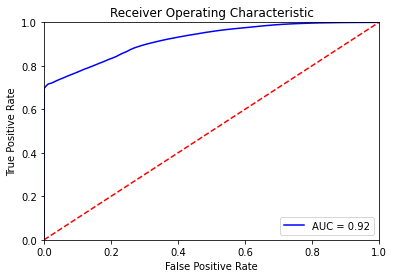

In [25]:
#AUC_ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
pred = model_conv1D.predict(x_test_bal_reshaped)
fpr, tpr, threshold = metrics.roc_curve(y_test_bal, pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Applying Undersampling

In [18]:
x_train_bal = train.drop('loan_status',axis =1)
x_test_bal = test.drop('loan_status',axis =1)
x_validation_bal = validation.drop('loan_status',axis =1)

y_train_bal = train['loan_status']
y_test_bal = test['loan_status']
y_validation_bal = validation['loan_status']

In [20]:
from imblearn.under_sampling import RandomUnderSampler 


In [21]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train_bal==1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train_bal==0)))

rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(x_train_bal, y_train_bal.ravel())

print('After UnderSampling, the shape of train_X: {}'.format(x_train_bal.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_bal.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_bal==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_bal==0)))

Before UnderSampling, counts of label '1': 52937
Before UnderSampling, counts of label '0': 738087 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After UnderSampling, the shape of train_X: (791024, 41)
After UnderSampling, the shape of train_y: (105874,) 

After UnderSampling, counts of label '1': 52937
After UnderSampling, counts of label '0': 52937


In [23]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_test_bal==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_test_bal==0)))

rus = RandomUnderSampler(random_state=42)
X_test_bal, y_test_bal = rus.fit_resample(x_test_bal, y_test_bal.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_test_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_test_bal.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_test_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_test_bal==0)))

Before OverSampling, counts of label '1': 52564
Before OverSampling, counts of label '0': 706270 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (758834, 41)
After OverSampling, the shape of train_y: (105128,) 

After OverSampling, counts of label '1': 52564
After OverSampling, counts of label '0': 52564


In [24]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_validation_bal==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_validation_bal==0)))

rus = RandomUnderSampler(random_state=42)
X_validation_bal, y_validation_bal = rus.fit_resample(x_validation_bal, y_validation_bal.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_validation_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_validation_bal.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_validation_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_validation_bal==0)))

Before OverSampling, counts of label '1': 5882
Before OverSampling, counts of label '0': 82010 

After OverSampling, the shape of train_X: (87892, 41)
After OverSampling, the shape of train_y: (11764,) 

After OverSampling, counts of label '1': 5882
After OverSampling, counts of label '0': 5882


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
x_train_bal_reshaped = X_train_bal.reshape(X_train_bal.shape[0],X_train_bal.shape[1],1)
x_test_bal_reshaped = X_test_bal.reshape(X_test_bal.shape[0],X_test_bal.shape[1],1)
x_validation_bal_reshaped = X_validation_bal.reshape(X_validation_bal.shape[0],X_validation_bal.shape[1],1)

In [26]:
model_conv1D = build_conv1D_model()
history = model_conv1D.fit(x_train_bal_reshaped, y_train_bal, epochs=10,
                    validation_data = (x_validation_bal_reshaped, y_validation_bal),callbacks = [Es])


Epoch 1/10
3309/3309 [==============================] - 26s 8ms/step - loss: 114.8748 - acc: 0.6470 - val_loss: 0.4935 - val_acc: 0.7801
Epoch 2/10
3309/3309 [==============================] - 25s 8ms/step - loss: 0.9238 - acc: 0.7129 - val_loss: 0.4446 - val_acc: 0.8187
Epoch 3/10
3309/3309 [==============================] - 25s 8ms/step - loss: 0.5286 - acc: 0.7759 - val_loss: 0.4574 - val_acc: 0.8246
Epoch 4/10
3309/3309 [==============================] - 26s 8ms/step - loss: 0.4402 - acc: 0.8221 - val_loss: 0.3206 - val_acc: 0.8666
Epoch 5/10
3309/3309 [==============================] - 26s 8ms/step - loss: 0.3337 - acc: 0.8616 - val_loss: 0.3065 - val_acc: 0.8674
Epoch 6/10
3309/3309 [==============================] - 25s 8ms/step - loss: 0.3282 - acc: 0.8605 - val_loss: 0.2931 - val_acc: 0.8744
Epoch 7/10
3309/3309 [==============================] - 25s 8ms/step - loss: 0.3198 - acc: 0.8632 - val_loss: 0.2863 - val_acc: 0.8752
Epoch 8/10
3309/3309 [==============================]

In [27]:
print("The testing accuracy is:", model_conv1D.evaluate(x_test_bal_reshaped, y_test_bal))

3286/3286 [==============================] - 8s 2ms/step - loss: 0.3205 - acc: 0.8516
The testing accuracy is: [0.3204999566078186, 0.8515619039535522]


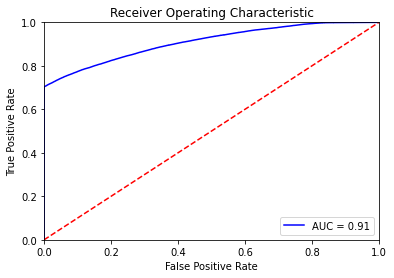

In [34]:
#AUC_ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
pred = model_conv1D.predict(x_test_bal_reshaped)
fpr, tpr, threshold = metrics.roc_curve(y_test_bal, pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()